## A Network Approach to Genetic and Expression based Phenotype Prediction on Mouse

Gianni Giusto, Yann Mentha, Raphaël Reis, Lucas Zweili

_Code available on the [GitHub](https://github.com/raphaelreis/Network_tour_of_mice_genetics) repository._

_____


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import seaborn as sns
from os import listdir 
import os.path

# Network
import networkx as nx
from pygsp import graphs, filters, plotting

# Classification + ML
from networkx.algorithms import node_classification
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import RFE


%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import helpers as hl

## 1. Summary

|          | Description                                                  |         Amount |
| -------- | ------------------------------------------------------------ | -------------: |
| nodes    | mice                                                         |      100 - 200 |
| edges    | similar genes, protein expressions, or phenotypes            | O(10) per node |
| features | genes, protein expressions in tissues, or phenotypes         |          1000s |
| labels   | depends: a particular gene, phenotype, or protein expression |            N/A |

## 2. Acquisition

In [3]:
data_folder = './../data/BXD data-3/'

##### *Genotype*

In [4]:
df_genotype = pd.read_csv(data_folder + 'genotype_BXD.txt', delimiter ="\t", index_col='SNP').transpose()
df_genotype.index.name = 'BDX_strain'
df_genotype.head()

SNP,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829,rs36742481,...,rs47382998,rs13484107,rs3693969,DXMit223,rs31638776,rs31639754,rs46326766,rs31412493,rs31417520,UT-M-9461
BDX_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,-1
D2B6F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,-1,-1,1
C57BL.6J,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
DBA.2J,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BXD1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1


##### *Phenotype*

In [5]:
df_phenotype = pd.read_csv(data_folder + "Phenotype.txt", delimiter="\t", index_col='PhenoID').transpose() 
df_phenotype.index.name = 'BXD_strain'
print(df_phenotype.shape)

(97, 5092)


## 3. Exploration 

#### 3.1 Build the network

In [6]:
# Adjacency for progeny strains only (remove P generations)
strains = df_genotype.index.to_list()[4:]
genotype_adjacency = hl.get_adjacency(df_genotype.loc[strains].to_numpy(), 'cosine', sigma=0.53, epsilon=0.27)

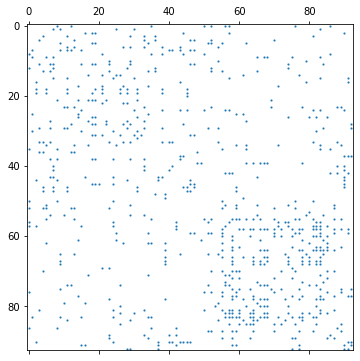

In [7]:
plt.subplots(figsize=(6,6))
plt.spy(genotype_adjacency, markersize=1)

C:\Users\Gianni\Anaconda3\envs\ntds_2019\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


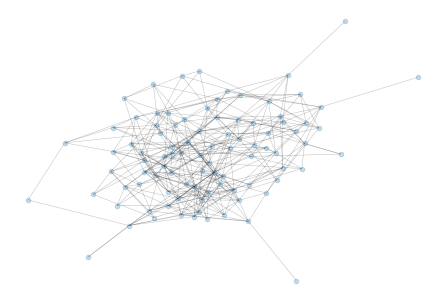

In [8]:
genotype_graph = nx.from_numpy_array(genotype_adjacency)
nx.draw(genotype_graph,node_size=20,width=0.5, alpha=0.25)

In [9]:
hl.graph_basic_stats(genotype_graph)

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  93    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 373    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │   8.72 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   8.02 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.26 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   6    │
╘═════════════════════════════════════════════════╧════════╛


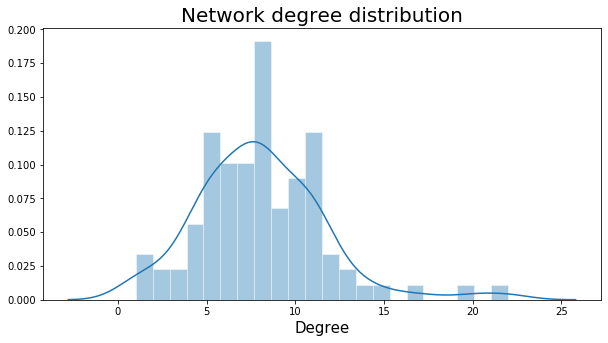

In [10]:
# Degree distribution
adj = genotype_adjacency.copy()
adj[genotype_adjacency > 0] = 1

degrees = adj.sum(1)
deg_hist_normalization = np.ones(degrees.shape[0]) / degrees.shape[0]

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Degree', fontsize=15)
ax.set_title('Network degree distribution', fontsize=20)
sns.distplot(degrees, ax=ax, bins=22, kde=True, hist_kws=dict(edgecolor="w", linewidth=1, weights=deg_hist_normalization))

In [11]:
fig.savefig('degree_distribution.png')

#### 3.2 Network simulation

##### *Erdos-Rényi network*

In [12]:
n = len(genotype_graph.nodes())
m = np.round(genotype_graph.size() / 2)

# Graph parameter
p = 2*m / (n * (n-1))
G_er = nx.erdos_renyi_graph(n, p)

print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 182 edges.


##### *Barabási-Albert network*

In [13]:
q=2
assert (q*(n-q) - m) < 50

G_ba = nx.barabasi_albert_graph(n, q)

print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 182 edges.


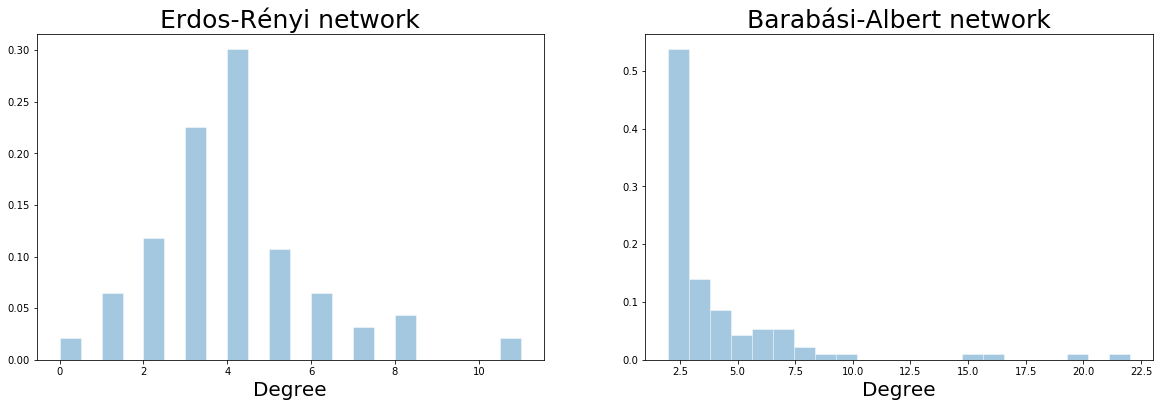

In [14]:
er_degrees = [degree for node, degree in G_er.degree()]
ba_degrees = [degree for node, degree in G_ba.degree()]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].set_xlabel('Degree', fontsize=20)
ax[0].set_title('Erdos-Rényi network', fontsize=25)
sns.distplot(er_degrees, ax=ax[0], bins=22, kde=False, hist_kws=dict(edgecolor="w", linewidth=1, weights=deg_hist_normalization))

ax[1].set_xlabel('Degree', fontsize=20)
ax[1].set_title('Barabási-Albert network', fontsize=25)
sns.distplot(ba_degrees, ax=ax[1], bins=22, kde=False, hist_kws=dict(edgecolor="w", linewidth=1, weights=deg_hist_normalization))

In [15]:
fig.savefig('generated_models.png')

#### 3.3 Grid search approach

## 4. Exploitation

#### 4.1 Feature imputation

##### 4.1.1 Baseline

In [19]:
expression_data_folder = data_folder + '/expression data/'

In [20]:
def open_expression_data(folder, txt_file):
    expression_data = pd.read_csv(folder + txt_file, delimiter ="\t", index_col='gene').transpose()
    expression_data.index.name = 'BXD_strain'
    
    return expression_data

In [21]:
expression_data_files = listdir(expression_data_folder)  
expression_data_files = [filename for filename in expression_data_files if filename.endswith(".txt")] # take only .txt files

In [22]:
df_expressions = [open_expression_data(expression_data_folder, f) for f in expression_data_files]
df_expression = pd.concat(df_expressions, ignore_index=False, sort=False, axis=1)
df_expression.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=0, inplace=True)

In [25]:
# Remove duplicated columns + replace by mean
df_expression = df_expression.groupby(by=df_expression.columns, axis=1).mean()

In [26]:
# select features
# count nan by cols: select cols with less than 20 nans
features = df_expression[df_expression.columns[df_expression.isna().sum(axis=0) < 20]] #df_expression.isna().sum(axis=0)
features.shape

(93, 71085)

In [27]:
# For baseline: replace nans by mean
features = features.fillna(features.mean())

In [28]:
labels = df_phenotype.loc[strains][['X62']]

In [29]:
nan_strains = df_phenotype.loc[df_phenotype['X62'].isnull()==True].index.to_list()

In [30]:
features.drop(nan_strains, axis=0, inplace=True)
features.shape

(90, 71085)

In [31]:
labels.drop(nan_strains, axis=0, inplace=True)
labels.shape

(90, 1)

In [32]:
# RFE - recusrsive feature elimination

l_r = logistic = LogisticRegression(solver='lbfgs', max_iter=4000, multi_class='auto')
rfe = RFE(l_r, step = 0.1, verbose = True)
fit = rfe.fit(features.to_numpy(), labels.to_numpy().ravel())
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Fitting estimator with 71085 features.
Fitting estimator with 63977 features.
Fitting estimator with 56869 features.
Fitting estimator with 49761 features.
Fitting estimator with 42653 features.
Fitting estimator with 35545 features.
Num Features: 35542
Selected Features: [ True False  True ... False  True False]
Feature Ranking: [1 6 1 ... 7 1 7]


In [33]:
selected_features = features.to_numpy()[:, rfe.support_]

In [34]:
logistic = LogisticRegression(solver='lbfgs', max_iter=4000, multi_class='auto')

accuracies = cross_val_score(logistic, selected_features, labels.to_numpy().ravel(), cv=5, scoring="accuracy")
print('Accuracy: {:.2f}'.format(np.mean(accuracies)))

Accuracy: 0.37


##### 4.1.2 Graph signal processing (GSP)

##### 4.1.3 Logistic regression following GSP

#### 4.2 Phenotype prediction

##### 4.2.1 Harmonic function

In [35]:
# Using a phenotype present on most strain: X63 (3 nans only)
df_phenotype.loc[df_phenotype['X62'].isnull()==True].index.to_list()

['BXD37', 'BXD41', 'BXD54']

In [36]:
labels = df_phenotype.loc[strains][['X62']] 
labels = labels.to_numpy().ravel()

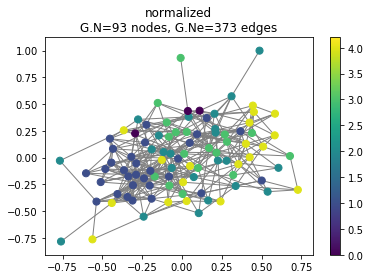

In [37]:
# Signal visualization
pygsp_graph = graphs.Graph(genotype_adjacency, 'normalized')
pygsp_graph.set_coordinates(kind='spring')
plotting.plot_signal(pygsp_graph, np.nan_to_num(labels, copy=True), backend=None, vertex_size=50)

In [38]:
nb_nodes = genotype_adjacency.shape[0]
train_mask, test_mask = hl.get_masks(nb_nodes, 0.1)

In [39]:
y_train = labels[train_mask]
y_test = labels[test_mask]

In [40]:
# Semi-supervised learning, assign training labels only
genotype_graph = nx.from_numpy_array(genotype_adjacency)

for node_number, node_value in zip(train_mask, y_train):
    genotype_graph.nodes[node_number]['label'] = node_value

In [41]:
# Classify remaining nodes
y_classification = node_classification.harmonic_function(genotype_graph)
y_hat = np.array(y_classification)[test_mask]

In [42]:
print('Accuracy: {:.2f}'.format(hl.compute_accuracy(y_test, y_hat)))
print('MCC: {:.2f}'.format(matthews_corrcoef(y_test, y_hat)))

Accuracy: 0.44
MCC: 0.21


##### 4.2.2 Logistic regression and RFE